In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
# current_dir = '/home/jiayuand/seqOED_variational/examples/location'
# parent_dir = '/home/jiayuand/seqOED_variational'

# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parent_dir = os.path.dirname(os.path.dirname(current_dir))
parent_dir = '../../../'
sys.path.insert(0, parent_dir) 

import numpy as np
# from scipy.stats import norm, beta, dirichlet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
if torch.cuda.is_available():  
    dev = "cuda" 
else:  
    dev = "cpu"  
device = torch.device(dev) 
torch.set_default_device(device)
dtype = torch.float32
torch.set_default_dtype(dtype)

from vsOED import VSOED, PGvsOED, GMM_NET, NFs, POST_APPROX
from vsOED.utils import *
from vsOED.models import *

import dowel
import joblib

print('==============================================================================')
print('Please go to /home/<USER>/.local/lib/python3.9/site-packages/torch/storage.py')
print('and change def _load_from_bytes(b):')
print('to')
print(f'    return torch.load(io.BytesIO(b), map_location="{dev}")')
print('==============================================================================')

Please go to /home/<USER>/.local/lib/python3.9/site-packages/torch/storage.py
and change def _load_from_bytes(b):
to
    return torch.load(io.BytesIO(b), map_location="cpu")


# Only interested in parameter of interest (poi)

In [377]:
data_folder = parent_dir + './results/source/unimodel/poi/'
subfolders = {'rl': './RL_BOED/',
              'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [378]:
# read in rl-boed results
rl_rwds = {}
rl_full_rwds = {}
rl_full_rwds['terminal'] = np.load(subfolders['rl'] + '/source_full_terminal_res.npy')
rl_full_rwds['terminal'] = np.moveaxis(rl_full_rwds['terminal'], -1, 0)
rl_full_rwds['incre'] = np.load(subfolders['rl'] + '/source_full_incre_res.npy')
rl_full_rwds['incre'] = np.moveaxis(rl_full_rwds['incre'], -1, 0)
rl_rwds['terminal'] = np.load(subfolders['rl'] + '/source_terminal_res.npy')
rl_rwds['terminal'] = np.moveaxis(rl_rwds['terminal'], -1, 0)
rl_rwds['incre'] = np.load(subfolders['rl'] + '/source_incre_res.npy')
rl_rwds['incre'] = np.moveaxis(rl_rwds['incre'], -1, 0)

In [379]:
# read in gmm results
hs = [1] + [3 * i for i in range(1, 11)]
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 2000, 11, 31), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation.pt', map_location=device)
                gmm_rwds[mode][id, :, k, :h+1] = res['rewards_hist'].numpy()
            except:
                pass
        

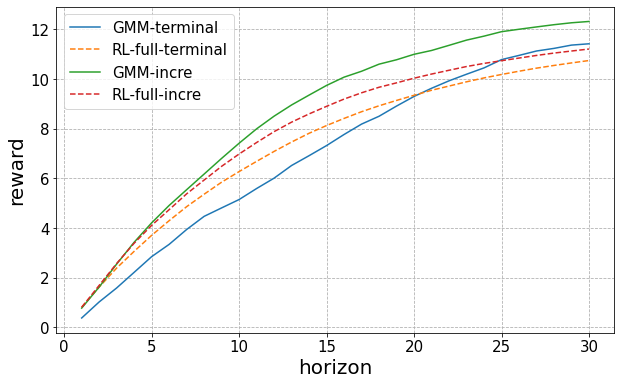

In [367]:
# draw evaluation of T=30, compared with fully trained
plt.figure(figsize=(10, 6))
stages = np.arange(1, 31)
for mode in ['terminal', 'incre']:
    rwds = np.nancumsum(np.nanmean(gmm_rwds[mode][:, :, -1, :], axis=(0, 1)), axis=-1)[:-1]
    plt.plot(stages, rwds, label=f'GMM-{mode}')
    plt.plot(stages, rl_full_rwds[mode].mean(axis=(0, 1)), label=f'RL-full-{mode}', ls='--')

plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')

/tmp/ipykernel_1987188/3092916746.py:5: RuntimeWarning: Mean of empty slice
  rwds = np.nansum(np.nanmean(gmm_rwds[mode], axis=(0, 1)), axis=1)
/tmp/ipykernel_1987188/3092916746.py:5: RuntimeWarning: Mean of empty slice
  rwds = np.nansum(np.nanmean(gmm_rwds[mode], axis=(0, 1)), axis=1)


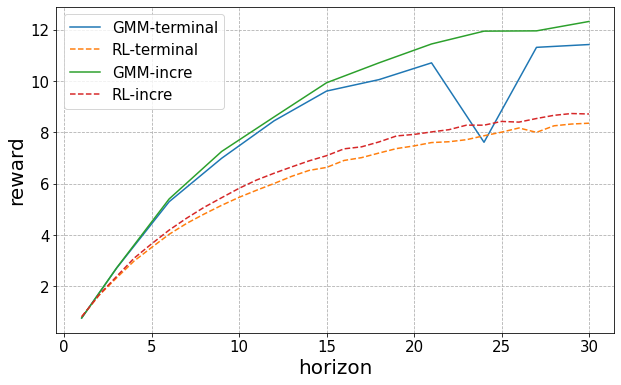

In [381]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
stages = np.arange(1, 31)
for mode in ['terminal', 'incre']:
    rwds = np.nansum(np.nanmean(gmm_rwds[mode], axis=(0, 1)), axis=1)
    plt.plot(hs, rwds, label=f'GMM-{mode}')
    plt.plot(stages, rl_rwds[mode].mean(axis=(0, 1)), label=f'RL-{mode}', ls='--')
plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')

In [298]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'terminal'
id = 0
h = 3
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation.pt', map_location=device)
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

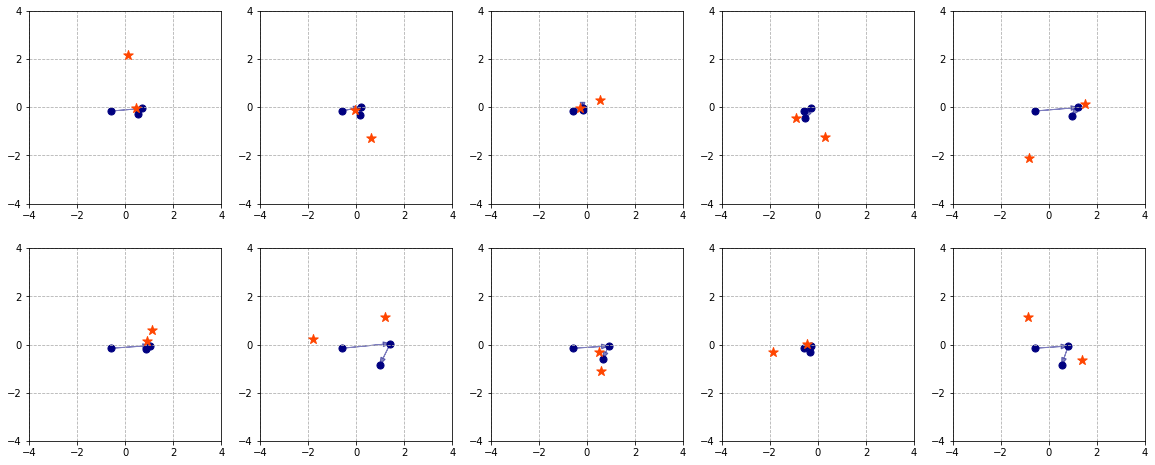

In [299]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 10, replace=False)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    for i in range(2):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.2, length_includes_head=True)
        d_old = d
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.grid(ls='--')

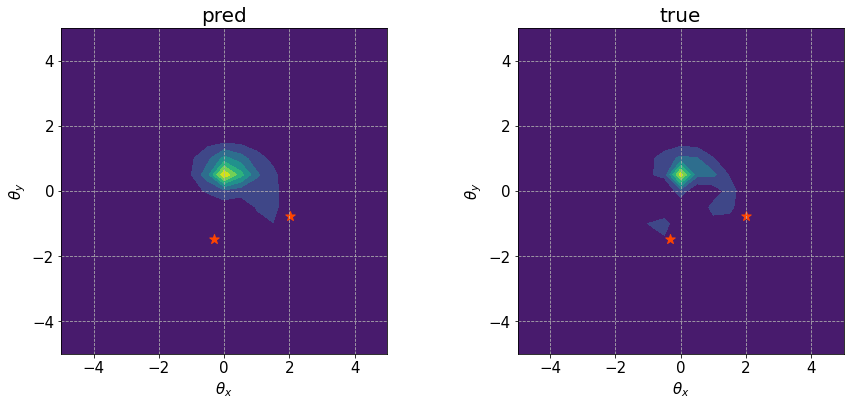

In [302]:
# randomly pick 1 index of samples, and draw the posterior
# np.random.seed(213)
idx = np.random.choice(len(params), 1, replace=False)[0]
# idx = 20
param_bounds =  [[-5, 5]] * 4
n_grid = 21
param_grids = [np.linspace(param_bounds[i][0], param_bounds[i][1], n_grid) for i in range(len(param_bounds))]
PARAM = np.meshgrid(*param_grids, indexing='ij')
PARAM = np.array(PARAM)
PARAM = np.moveaxis(PARAM, 0, -1)
PARAM_tensor = torch.from_numpy(np.array(PARAM)).view(-1, len(param_bounds))
net = vsoed.post_approx.poi_post_nets[h - 1][0]

param = params[idx].numpy()
d_hist = ds_hist[idx].numpy()
y_hist = ys_hist[idx].numpy()

X = vsoed.post_approx.form_input(h, ds_hist[idx:idx+1], ys_hist[idx:idx+1])
X = X.expand(len(PARAM_tensor), -1)
with torch.no_grad():
    logpost_pred = net(X, PARAM_tensor)
post_pred = torch.exp(logpost_pred).reshape([n_grid]*len(param_bounds))
post_pred = post_pred.cpu().numpy()

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1, aspect='equal')
XY = PARAM[:, :, 0, 0, 0:2]
X = XY[:, :, 0]
Y = XY[:, :, 1]
post = post_pred.sum(axis=(-1,-2))
plt.contourf(X, Y, post)
plt.scatter(param[0], param[1], s=100, c='orangered', marker='*')
plt.scatter(param[2], param[3], s=100, c='orangered', marker='*')
plt.title('pred', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$\\theta_x$', fontsize=15)
plt.ylabel('$\\theta_y$', fontsize=15)
plt.grid(ls='--')

logprior_true = vsoed.prior.log_poi_prior(PARAM_tensor)
loglikeli_true = 0
for stage in range(h):
    loglikeli_true += vsoed.loglikeli(h, ys_hist[idx][stage:stage+1], PARAM_tensor, ds_hist[idx][stage:stage+1])
logpost_true = logprior_true + loglikeli_true
post_true = torch.exp(logpost_true).reshape([n_grid]*len(param_bounds))

plt.subplot(1, 2, 2, aspect='equal')
post = post_true.sum(axis=(-1,-2))
plt.contourf(X, Y, post)
plt.scatter(param[0], param[1], s=100, c='orangered', marker='*')
plt.scatter(param[2], param[3], s=100, c='orangered', marker='*')
plt.title('true', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$\\theta_x$', fontsize=15)
plt.ylabel('$\\theta_y$', fontsize=15)
plt.grid(ls='--')

plt.show()

# Only interested in goal-oriented (goal)

In [382]:
data_folder = parent_dir + './results/source/unimodel/goal/'
subfolders = {'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [383]:
# read in gmm results
hs = [1, 5, 10, 15, 20, 30]
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 6), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation_with_post_approx.pt', map_location=device)
                gmm_rwds[mode][id, k] = res['averaged_reward']
            except:
                pass
        

In [384]:
gmm_rwds['incre']

array([[0.15882432, 0.97523785, 1.3963058 , 1.77572775, 1.89748025,
        2.09106755],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]])

In [385]:
gmm_rwds['terminal']

array([[0.15969844, 0.95518911, 1.39154327, 1.617697  , 1.77162027,
        1.53564322],
       [0.16139784, 0.75976449, 1.20635509, 1.49702966, 1.68649364,
        1.68928325],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]])

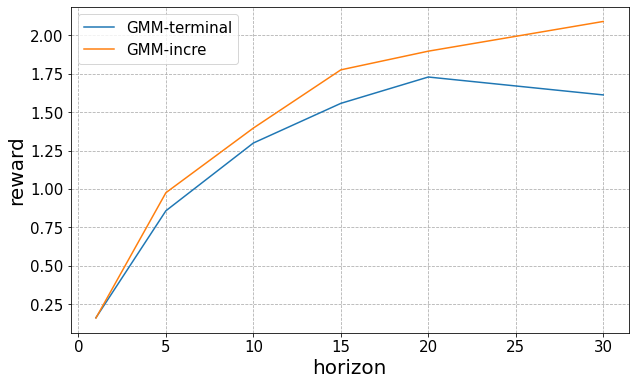

In [386]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
stages = np.arange(1, 31)
for mode in ['terminal', 'incre']:
    rwds = np.nanmean(gmm_rwds[mode], axis=0)
    # rwds[np.isnan(rwds)] = 0
    plt.plot(hs, rwds, label=f'GMM-{mode}')
plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.show()

In [387]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'terminal'
id = 0
h = 10
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation.pt', map_location=device)
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

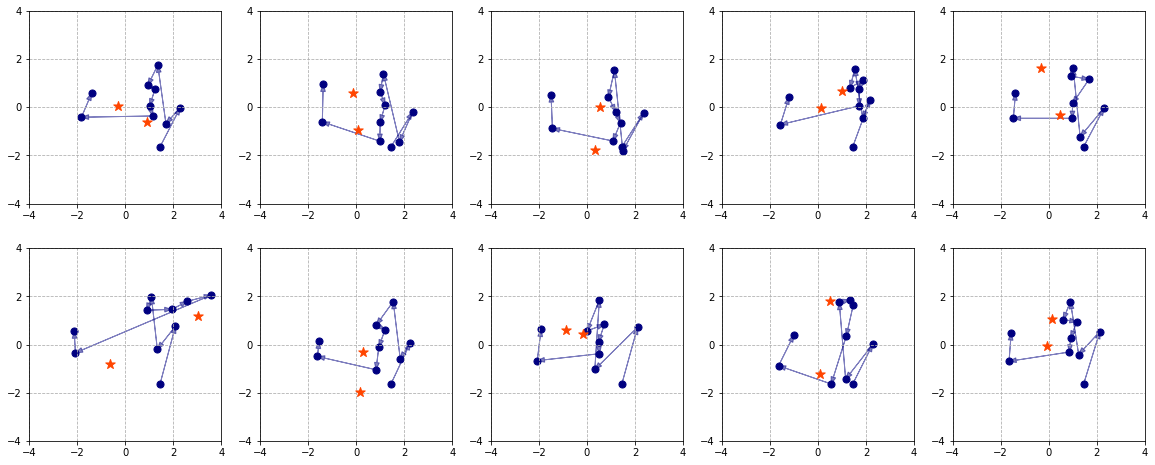

In [388]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(569)
idxs = np.random.choice(len(params), 10, replace=False)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    for i in range(2):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.2, length_includes_head=True)
        d_old = d
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.grid(ls='--')

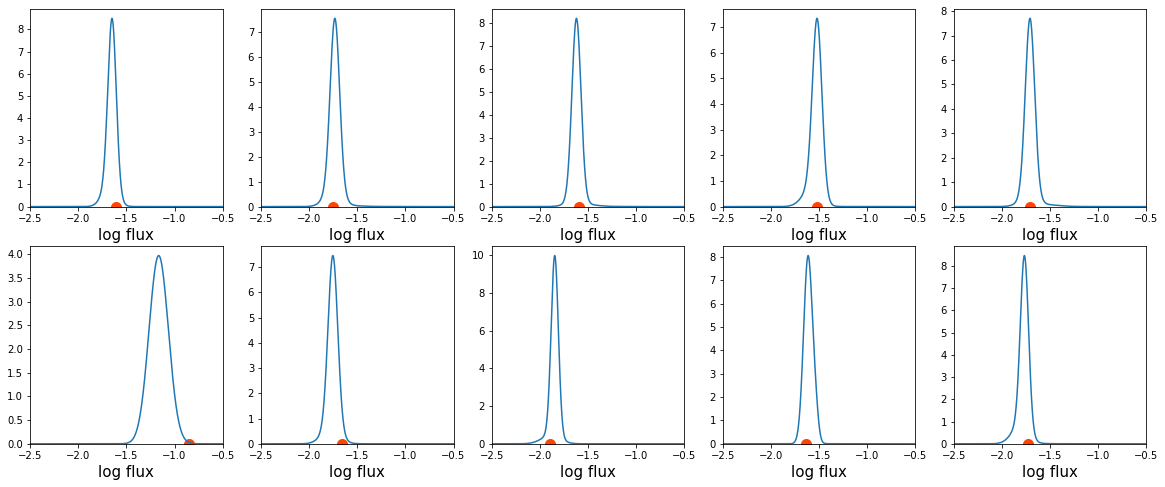

In [389]:
# randomly pick 10 index of samples, and draw the posterior
# np.random.seed(1369)
# idxs = np.random.choice(len(params), 10, replace=False)
param_bounds =  [-2.5, -0.5]
n_grid = 1001
param_grids = np.linspace(param_bounds[0], param_bounds[1], n_grid)
PARAM_tensor = torch.from_numpy(param_grids).view(-1, 1)
net = vsoed.post_approx.goal_post_nets[h - 1][0]

plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()

    X = vsoed.post_approx.form_input(h, ds_hist[idx:idx+1], ys_hist[idx:idx+1])
    X = X.expand(len(PARAM_tensor), -1)
    with torch.no_grad():
        logpost_pred = net(X, PARAM_tensor)
    post_pred = torch.exp(logpost_pred)
    post_pred = post_pred.cpu().numpy()
    plt.plot(param_grids, post_pred)
    plt.scatter(param[-1], 0, s=100, c='orangered')
    
    plt.xlim(*param_bounds)
    plt.ylim(0, )
    plt.xlabel('log flux', fontsize=15)

plt.show()

In [320]:
# try to draw the posteriors of batch vertical designns and horizontal designs

In [ ]:
# randomly pick 10 index of samples, and draw the posterior
# np.random.seed(1369)
# idxs = np.random.choice(len(params), 10, replace=False)
param_bounds =  [-2.5, -0.5]
n_grid = 1001
param_grids = np.linspace(param_bounds[0], param_bounds[1], n_grid)
PARAM_tensor = torch.from_numpy(param_grids).view(-1, 1)
net = vsoed.post_approx.goal_post_nets[h - 1][0]
contrast_params = vsoed.prior_rvs(int(1e6))

plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()

    X = vsoed.post_approx.form_input(h, ds_hist[idx:idx+1], ys_hist[idx:idx+1])
    X = X.expand(len(PARAM_tensor), -1)
    with torch.no_grad():
        logpost_pred = net(X, PARAM_tensor)
    post_pred = torch.exp(logpost_pred)
    post_pred = post_pred.cpu().numpy()
    plt.plot(param_grids, post_pred)
    plt.scatter(param[-1], 0, s=100, c='orangered')
    
    plt.xlim(*param_bounds)
    plt.ylim(0, )
    plt.xlabel('log flux', fontsize=15)

plt.show()

In [392]:
contrast_params = vsoed.prior_rvs(int(1e6))

In [394]:
contrast_params.shape

torch.Size([1000000, 5])

In [396]:
vsoed.model.loglikeli(0, ys_hist[0][0:1], contrast_params, ds_hist[0][0:1]).shape

torch.Size([1000000])

# Only interested in goal-oriented, with nuisance parameters (nuis_goal)

In [332]:
data_folder = parent_dir + './results/source/unimodel/nuis_goal/'
subfolders = {'gmm': data_folder + 'GMM/',
              'nfs': data_folder + 'NFs/'}

In [323]:
# read in gmm results
hs = [1, 5, 10, 15, 20, 30]
gmm_rwds = {}
for mode in ('terminal', 'incre'):
    gmm_rwds[mode] = np.full((4, 6), np.nan)
    for id in range(4):
        for k, h in enumerate(hs):
            try:
                res = torch.load(subfolders['gmm'] + f'/{mode}_id{id}_h{h}/evaluation_with_post_approx.pt', map_location=device)
                gmm_rwds[mode][id, k] = res['averaged_reward']
            except:
                pass
        

/tmp/ipykernel_1987188/3181573244.py:5: RuntimeWarning: Mean of empty slice
  rwds = np.nanmean(gmm_rwds[mode], axis=0)


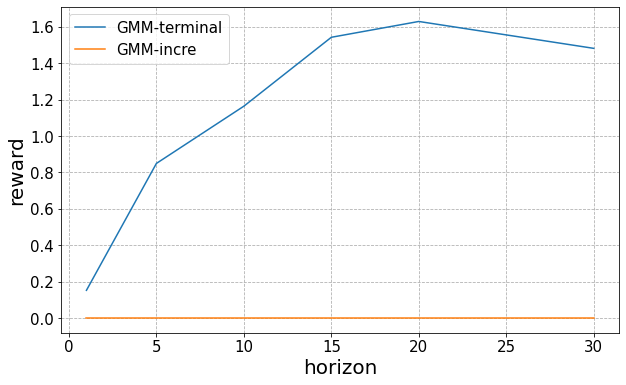

In [325]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
stages = np.arange(1, 31)
for mode in ['terminal', 'incre']:
    rwds = np.nanmean(gmm_rwds[mode], axis=0)
    rwds[np.isnan(rwds)] = 0
    plt.plot(hs, rwds, label=f'GMM-{mode}')
plt.legend(fontsize=15)
plt.xlabel('horizon', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.show()

In [335]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'terminal'
id = 0
h = 20
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + 'evaluation.pt', map_location=device)
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

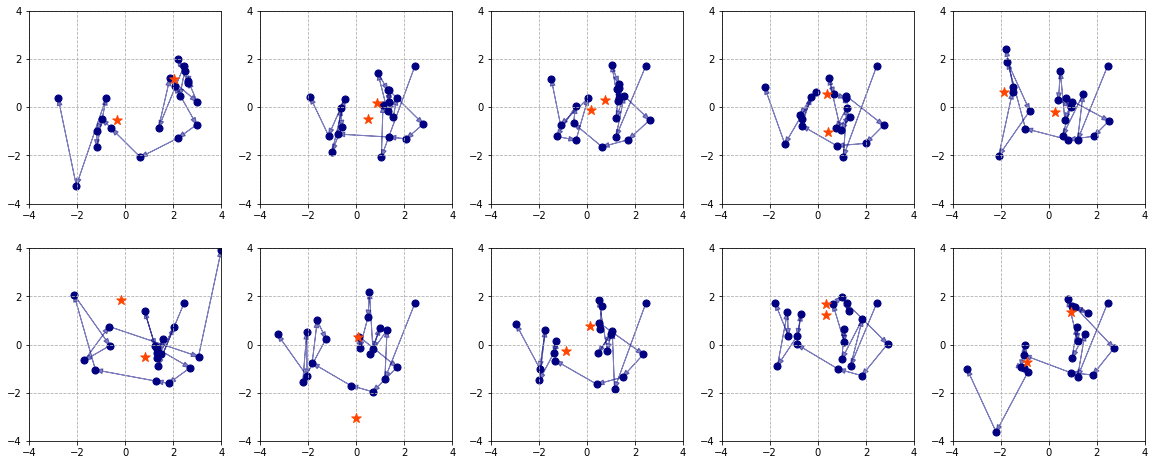

In [336]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(569)
idxs = np.random.choice(len(params), 10, replace=False)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    for i in range(2):
        plt.scatter(param[i*2], param[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.2, length_includes_head=True)
        d_old = d
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-4, 4, 5))
    plt.grid(ls='--')

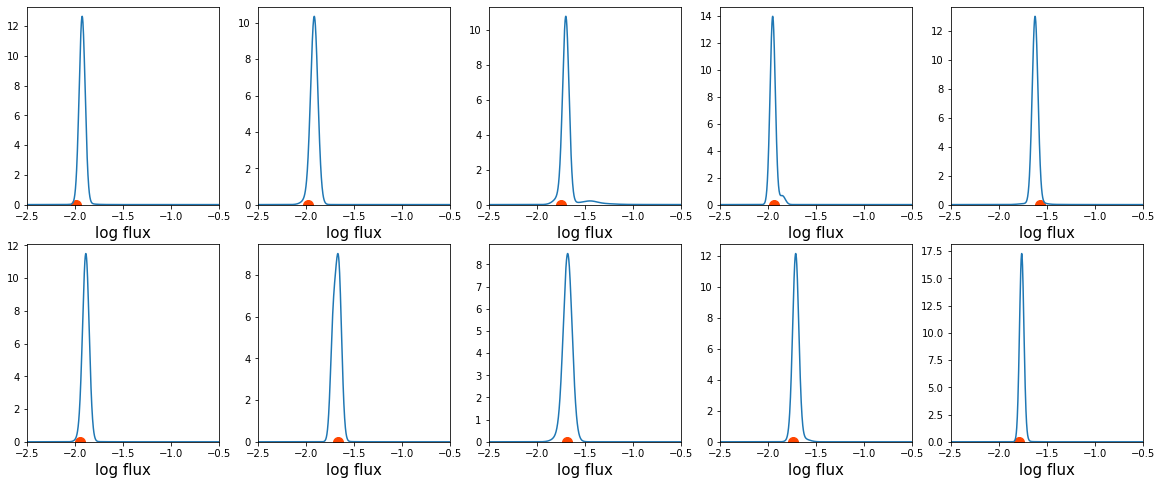

In [344]:
# randomly pick 10 index of samples, and draw the posterior
# np.random.seed(1369)
idxs = np.random.choice(len(params), 10, replace=False)
param_bounds =  [-2.5, -0.5]
n_grid = 1001
param_grids = np.linspace(param_bounds[0], param_bounds[1], n_grid)
PARAM_tensor = torch.from_numpy(param_grids).view(-1, 1)
net = vsoed.post_approx.goal_post_nets[h - 1][0]

plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()

    X = vsoed.post_approx.form_input(h, ds_hist[idx:idx+1], ys_hist[idx:idx+1])
    X = X.expand(len(PARAM_tensor), -1)
    with torch.no_grad():
        logpost_pred = net(X, PARAM_tensor)
    post_pred = torch.exp(logpost_pred)
    post_pred = post_pred.cpu().numpy()
    plt.plot(param_grids, post_pred)
    plt.scatter(param[-1], 0, s=100, c='orangered')
    
    plt.xlim(*param_bounds)
    plt.ylim(0, )
    plt.xlabel('log flux', fontsize=15)

plt.show()